### Final Propensity matching results

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )
import data_process
from tqdm import tqdm
from path import col_seq_can_all, col_seq_can 
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

In [5]:
# #setup cython
# #for cython build if needed -> cd to /modules folder and then run
# %cd ..
# !python3 setup.py build_ext --inplace
# %cd ./causal_data_creation/canary_application/

In [6]:
%config Completer.use_jedi = False

### Load pre matching data

In [7]:
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/Pre_Matching_DATA ./Pre_Matching_DATA --recursive;

In [8]:
# !aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/CANARY_PAPER/DATA/tempHybridSelectionMoreData/random.p ./Pre_Matching_DATA/random.p;

In [9]:
pp_str = 'Pre_Matching_DATA/'

treated2 = pd.read_pickle(pp_str+'treated2.p')
controls = pd.read_pickle(pp_str+'controls.p')
pmpm =pd.read_pickle(pp_str+'pmpm.p')
random_controls = pd.read_pickle(pp_str+'random.p')

In [10]:
treated2.shape

In [11]:
controls.shape

In [12]:
pmpm.shape

# Transform data into PCA Latent Space

In [13]:
from sklearn.preprocessing import StandardScaler

In [25]:
scaler =  StandardScaler()
tr2 = scaler.fit_transform(treated2[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":])
cntrls = scaler.fit_transform(controls[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":])
pmpm.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
pmpm_lat = scaler.fit_transform(pmpm[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":])
rndm = scaler.fit_transform(random_controls[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":])

In [41]:
tr2 = pd.DataFrame(tr2, columns=treated2[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":].columns)
cntrls = pd.DataFrame(cntrls, columns=controls[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":].columns)
pmpm_lat = pd.DataFrame(pmpm_lat, columns=pmpm[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":].columns)
rndm = pd.DataFrame(rndm, columns=random_controls[col_seq_can_all].loc[:,"AGE_AT_MIDMONTH":].columns)

In [73]:
from sklearn.decomposition import PCA
pca = PCA(n_components=16)
tr2_pca  = pca.fit_transform(tr2)
cntrls_pca = pca.fit_transform(cntrls)
pmpm_lat_pca = pca.fit_transform(pmpm_lat)
rndm_pca = pca.fit_transform(rndm)

In [77]:
onset = "CC_DIABETES"
cols_to_keep = ["PERS_ID", "MYR", 'AGE_AT_MIDMONTH', 'MBR_GNDR', onset]
latent_cols = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16']

In [78]:
tr2_pca = pd.DataFrame(tr2_pca, columns=latent_cols)
cntrls_pca = pd.DataFrame(cntrls_pca, columns=latent_cols)
pmpm_lat_pca = pd.DataFrame(pmpm_lat_pca, columns=latent_cols)
rndm_pca = pd.DataFrame(rndm_pca, columns=latent_cols)

In [82]:
tr2 = pd.concat([treated2[cols_to_keep], tr2_pca], axis=1)
cntrls = pd.concat([controls[cols_to_keep], cntrls_pca], axis=1)
pmpm_lat = pd.concat([pmpm[cols_to_keep], pmpm_lat_pca], axis=1)
rndm = pd.concat([random_controls[cols_to_keep], rndm_pca], axis=1)

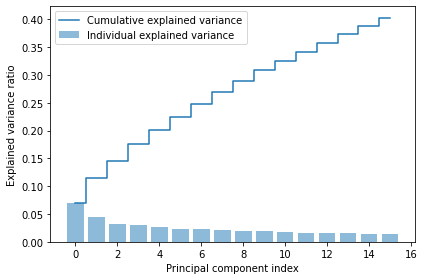

In [74]:
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Pick Columns for matching

In [88]:
columns_to_match =  ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6','LOB']

all_columns1 = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB',
                                                         'IP_BIN', 'ER_BIN', 'ACUTE', 'IP_C', 'ER_C', 'ACUTE_C','IP_BIN2', 'ER_BIN2']))

all_columns2 = list(set(all_columns1)-set(['IP_BIN6', 'ER_BIN6', 'LOB']))

In [89]:
%%time

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
match_on = latent_cols
hier_cols = ['IP_BIN6', 'ER_BIN6']
hier_range = [1,1]
exact_match_dict = {'IP_BIN6':[0,1,2], 'ER_BIN6':[0,1,2], 'LOB':None}
nnr_func_args = {'match_on':match_on, 'hier_cols':None,
                        'hier_range':None, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': False, 'exact_match_dict': None}
matched0, matched_data0 = matched_population(tr2.copy(), 
                                           cntrls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)

Mathcing Function: nearest_neighbor_func
hERE
After filtering control ids are:328522 before they were:354792


1604it [57:23,  2.15s/it]

CPU times: user 55min 6s, sys: 40min 52s, total: 1h 35min 58s
Wall time: 57min 28s


####  In addition to the previously created matched groups create a random group

In [90]:
Path('./tempPCA').mkdir(exist_ok = True)
p = './tempPCA/'
matched_data0.to_pickle(p+'match0_l.p')
tr2.to_pickle(p+'treated0_l.p')

In [91]:
matched_data0_o = controls[controls.set_index(["PERS_ID", "MYR"]).index.isin(matched_data0.set_index(["PERS_ID", "MYR"]).index)].sort_values(by=["PERS_ID", "MYR"])

In [92]:
matched_data0_o.to_pickle(p+"match0_o.p")

In [93]:
rndm.to_pickle(p+"random_l.p")

In [94]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [95]:
from utils import statistics_first_month, p_val, stat_matrices 

### List containing all numerical columns

In [96]:
all_columns = list(set(col for col in pmpm.columns)-set(['PERS_ID', 'MYR','MEDICAID_LOB']))

### Stats First Month(Treated and Matched Controls)

In [97]:
%%time
tr_desc0, treated_first_month = statistics_first_month(treated2, all_columns, return_array = True)
con_desc0, controls_first_month = statistics_first_month(matched_data0_o, all_columns, return_array = True)

CPU times: user 3.12 s, sys: 37.4 ms, total: 3.15 s
Wall time: 3.15 s


### Stats First Month(General Pop and Random)

In [98]:
%%time
pmpm_desc = statistics_first_month(pmpm2, all_columns)
random_desc = statistics_first_month(random_controls, all_columns)

CPU times: user 2min 25s, sys: 5.2 s, total: 2min 30s
Wall time: 2min 30s


In [99]:
%%time
conds_first, full_first = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = columns_to_match)
conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 28.6 ms, sys: 854 µs, total: 29.4 ms
Wall time: 27.6 ms


## Statistics on matching date

In [100]:
conds_first.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.206           50.374  -0.473  0.636             44.311   47.606
ALLOW_AMT        693.750          804.152  -1.723  0.085           1065.926  648.803
MBR_GNDR           0.206            0.205   0.044  0.965              0.443    0.431
CC_TOBACCO         0.061            0.104  -5.206  0.000              0.074    0.098
CC_PRESSURE        0.001            0.009  -3.109  0.002              0.007    0.007
CC_OBESITY         0.456            0.295  12.321  0.000              0.109    0.228
CC_HYPERTENSION    0.325            0.325   0.012  0.990              0.208    0.249
CC_HYPOTHYROID     0.095            0.060   4.991  0.000              0.047    0.063
CC_DX_CNT          2.706            2.536   2.931  0.003              1.824    2.344
ACUTE2             0.039            0.076  -4.927  0.000              0.063    0.052
ACUTE6             0.112            0.176  -4.836  0.000              0.063    0.153
IP_BIN6            0.028            0.038  -1.668  0.095              0.021    0.047
ER_BIN6            0.089            0.144  -4.705  0.000              0.047    0.116
LOB                0.952            0.819  13.268  0.000              0.756    0.788

In [101]:
full_first

Treated                    Matched Controls                       Test-TC               General Population                         Test-TG                    Random                       Test-TR              
                       mean          std count             mean          std count     t-stat          pval               mean          std   count     t-stat          pval        mean          std count     t-stat          pval
AGE_AT_MIDMONTH   50.205736    12.733903  1604        50.374283    12.695985  6105  -0.472860  6.363266e-01          44.310976    20.053585  356446  11.762030  6.207968e-32   47.606399    19.811819  7876   5.046484  4.583703e-07
ALLOW_AMT        693.750000  2216.211182  1604       804.152007  2301.450354  6105  -1.722781  8.496827e-02        1065.926022  6933.418650  356446  -2.149328  3.160904e-02  648.802692  3166.090228  7876   0.542150  5.877276e-01
MBR_GNDR           0.205736     0.404364  1604         0.205242     0.403911  6105   0.043585  9.652365e-01           0.442749     0.496712  356446 -19.081951  3.914644e-81    0.431056     0.495255  7876 -17.097185  1.439342e-64
CC_TOBACCO         0.061097     0.239583  1604         0.103849     0.305090  6105  -5.206154  1.977748e-07           0.074202     0.262100  356446  -1.998705  4.564109e-02    0.098400     0.297874  7876  -4.714462  2.458070e-06
CC_PRESSURE        0.001247     0.035300  1604         0.008518     0.091905  6105  -3.108623  1.886460e-03           0.007390     0.085645  356446  -2.871419  4.086576e-03    0.006602     0.080991  7876  -2.598386  9.380812e-03
CC_OBESITY         0.456359     0.498247  1604         0.295495     0.456303  6105  12.320691  1.480160e-34           0.108841     0.311440  356446  44.434357  0.000000e+00    0.228035     0.419592  7876  19.209513  1.041149e-80
CC_HYPERTENSION    0.324813     0.468451  1604         0.324652     0.468283  6105   0.012256  9.902217e-01           0.207717     0.405674  356446  11.525694  9.915163e-31    0.249365     0.432673  7876   6.274847  3.652926e-10
CC_HYPOTHYROID     0.094763     0.292979  1604         0.059787     0.237111  6105   4.991015  6.137895e-07           0.047300     0.212281  356446   8.916454  4.836392e-19    0.063484     0.243847  7876   4.516264  6.370084e-06
CC_DX_CNT          2.706359     2.227360  1604         2.535627     2.034777  6105   2.930699  3.391930e-03           1.824419     2.412274  356446  14.614465  2.345498e-48    2.343702     2.439688  7876   5.504457  3.799632e-08
ACUTE2             0.038653     0.208377  1604         0.075512     0.279893  6105  -4.927406  8.506522e-07           0.063258     0.243426  356446  -4.041413  5.314111e-05    0.051549     0.237733  7876  -2.020160  4.339483e-02
ACUTE6             0.111596     0.412699  1604         0.175594     0.486004  6105  -4.835577  1.353324e-06           0.063258     0.243426  356446   7.901966  2.753095e-15    0.153377     0.475791  7876  -3.274968  1.060534e-03
IP_BIN6            0.028055     0.199403  1604         0.038165     0.220251  6105  -1.667657  9.542440e-02           0.020587     0.141996  356446   2.097153  3.598074e-02    0.046851     0.263725  7876  -2.701482  6.915408e-03
ER_BIN6            0.088529     0.359723  1604         0.143980     0.434512  6105  -4.704945  2.583595e-06           0.047286     0.212251  356446   7.732311  1.058846e-14    0.116176     0.402957  7876  -2.548765  1.082613e-02
LOB                0.951995     0.213843  1604         0.819492     0.384641  6105  13.267936  9.670154e-40           0.755775     0.429627  356446  18.281467  1.257397e-74    0.787836     0.408866  7876  15.649481  1.606802e-54

### Statistics Over all dates (treated, controls)

In [102]:
%%time
tr_desc0A = treated2[all_columns].describe().loc[['mean', 'std', 'count']].T
tr_desc0A['count'] = tr_desc0A['count'].astype(int)

con_desc0A = matched_data0_o[all_columns].describe().loc[['mean', 'std', 'count']].T
con_desc0A['count'] = con_desc0A['count'].astype(int)

CPU times: user 705 ms, sys: 231 µs, total: 705 ms
Wall time: 704 ms


### Statistics Over all dates (general population, Random)

In [103]:
%%time
pmpm_descA = pmpm2[all_columns].describe().loc[['mean', 'std', 'count']].T
pmpm_descA['count'] = pmpm_descA['count'].astype(int)

random_descA = random_controls[all_columns].describe().loc[['mean', 'std', 'count']].T
random_descA['count'] = random_descA['count'].astype(int)

CPU times: user 29.4 s, sys: 2.44 s, total: 31.8 s
Wall time: 31.8 s


In [104]:
%%time
conds, full = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = columns_to_match)
conds_AllCols, full_AllCols = stat_matrices(tr_desc0A, con_desc0A, pmpm_descA, random_descA, columns = all_columns)

CPU times: user 30.2 ms, sys: 530 µs, total: 30.7 ms
Wall time: 28.9 ms


In [105]:
conds.round(3)

Treated Matched Controls Test-TC        General Population   Random
                    mean             mean  t-stat   pval               mean     mean
AGE_AT_MIDMONTH   50.837           51.269  -4.995  0.000             50.379   50.236
ALLOW_AMT        782.435          838.923  -1.831  0.067            857.856  706.609
MBR_GNDR           0.189            0.201  -4.004  0.000              0.433    0.429
CC_TOBACCO         0.063            0.118 -25.417  0.000              0.102    0.100
CC_PRESSURE        0.002            0.009 -10.512  0.000              0.013    0.008
CC_OBESITY         0.505            0.344  47.784  0.000              0.255    0.286
CC_HYPERTENSION    0.325            0.342  -5.059  0.000              0.329    0.300
CC_HYPOTHYROID     0.095            0.078   8.799  0.000              0.078    0.075
CC_DX_CNT          2.918            2.870   2.985  0.003              2.955    2.759
ACUTE2             0.032            0.052 -12.597  0.000              0.060    0.050
ACUTE6             0.100            0.158 -18.158  0.000              0.168    0.150
IP_BIN6            0.025            0.043 -11.133  0.000              0.055    0.049
ER_BIN6            0.079            0.123 -15.793  0.000              0.122    0.111
LOB                0.953            0.814  55.331  0.000              0.802    0.803

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [106]:
columns_to_match

['AGE_AT_MIDMONTH',
 'ALLOW_AMT',
 'MBR_GNDR',
 'CC_TOBACCO',
 'CC_PRESSURE',
 'CC_OBESITY',
 'CC_HYPERTENSION',
 'CC_HYPOTHYROID',
 'CC_DX_CNT',
 'ACUTE2',
 'ACUTE6',
 'IP_BIN6',
 'ER_BIN6',
 'LOB']

In [107]:
mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco Use', 'Pressure', 'Obesity', 
                                     'Hypertension', 'Hypothyroid', 'Disease Count','Acute Care 2 Months', 'Acute Care 6 Months',
                                      'Inpatient Visits 6 Months', 'Emergency Vistits 6 Months', 'Line of Bussiness']))
mapping2 = dict(zip(all_columns, all_columns))
#mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [108]:
base_path =  './results/PCA/'
p = Path(base_path)
p.mkdir(parents = True, exist_ok = True)

In [109]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

In [110]:
from diabetes_onset_plotter import plot_hist, save_arrays, save_arrays2


#### remove %%capture to see output

In [111]:
%%capture

dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping2, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_all/',
                dist_plot_args = dist_plot_args)

In [112]:
%%capture
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = base_path+'figures/distributions_selection/',
                dist_plot_args = dist_plot_args)

# Latent Space Stat

In [113]:
latent_cols

['x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'x8',
 'x9',
 'x10',
 'x11',
 'x12',
 'x13',
 'x14',
 'x15',
 'x16']

In [114]:
%%time
tr_desc0_l, treated_first_month = statistics_first_month(tr2, latent_cols, return_array = True)
con_desc0_l, controls_first_month = statistics_first_month(matched_data0, latent_cols, return_array = True)

CPU times: user 2.19 s, sys: 24.9 ms, total: 2.22 s
Wall time: 2.22 s


In [55]:
# pmpm_lat = data_process.transform_features_with_NN(model, pmpm[col_seq_can_all].copy(), cols_to_keep, latent_dim=16)

In [115]:
%%time
pmpm_desc_l = statistics_first_month(pmpm_lat, latent_cols)
random_desc_l = statistics_first_month(rndm, latent_cols)

CPU times: user 1min 47s, sys: 1.88 s, total: 1min 49s
Wall time: 1min 49s


In [116]:
%%time
conds_first_latent, full_first_latent = stat_matrices(tr_desc0_l, con_desc0_l, pmpm_desc_l, random_desc_l, columns = latent_cols)
#conds_firstAllCols, full_firstAllCols = stat_matrices(tr_desc0, con_desc0, pmpm_desc, random_desc, columns = all_columns)

CPU times: user 15.2 ms, sys: 308 µs, total: 15.5 ms
Wall time: 14.5 ms


In [117]:
conds_first_latent

Treated Matched Controls   Test-TC               General Population    Random
         mean             mean    t-stat          pval               mean      mean
x1  -0.115622        -0.318194  4.453372  8.572397e-06          -0.815929 -0.329949
x2  -0.048595        -0.139193  2.229800  2.578942e-02          -0.027686  0.013013
x3   0.096174         0.109608 -0.355813  7.219901e-01          -0.000098 -0.028882
x4   0.033811        -0.114286  4.404785  1.073200e-05           0.148295  0.089315
x5   0.064456         0.044163  0.703714  4.816320e-01           0.236600  0.033925
x6  -0.053528        -0.175774  5.214305  1.893035e-07           0.083527  0.041521
x7   0.003700        -0.001662  0.291755  7.704818e-01          -0.145144  0.053435
x8   0.088007        -0.005448  3.967670  7.323684e-05          -0.125045 -0.026507
x9   0.038991         0.056968 -0.817269  4.138002e-01           0.045020  0.005043
x10  0.007334         0.112798 -5.324304  1.041986e-07           0.004457 -0.022513
x11  0.016183        -0.184963  9.459469  4.028143e-21          -0.025876 -0.032429
x12  0.023704        -0.027680  2.238318  2.522879e-02          -0.090586 -0.056207
x13  0.018239         0.006335  0.533839  5.934683e-01           0.023893  0.051427
x14  0.041951         0.022104  0.968402  3.328742e-01          -0.008066 -0.063559
x15 -0.016654        -0.009702 -0.313687  7.537669e-01          -0.012703 -0.031379
x16  0.004686        -0.000076  0.227007  8.204242e-01          -0.032141  0.029536

In [118]:
full_first_latent

Treated                 Matched Controls                   Test-TC               General Population                      Test-TG                  Random                   Test-TR          
         mean       std count             mean       std count    t-stat          pval               mean       std   count     t-stat          pval      mean       std count    t-stat      pval
x1  -0.115622  2.031190  1604        -0.318194  1.494999  6105  4.453372  8.572397e-06          -0.815929  1.925372  356446  14.530853  7.971703e-48 -0.329949  2.064548  7876  3.799994  0.000146
x2  -0.048595  1.894418  1604        -0.139193  1.305839  6105  2.229800  2.578942e-02          -0.027686  1.534722  356446  -0.543785  5.865895e-01  0.013013  1.750787  7876 -1.266406  0.205399
x3   0.096174  1.754928  1604         0.109608  1.215507  6105 -0.355813  7.219901e-01          -0.000098  1.416700  356446   2.712254  6.683051e-03 -0.028882  1.546565  7876  2.882538  0.003954
x4   0.033811  1.997790  1604        -0.114286  0.874584  6105  4.404785  1.073200e-05           0.148295  1.332946  356446  -3.422571  6.203890e-04  0.089315  1.595717  7876 -1.212888  0.225203
x5   0.064456  1.916834  1604         0.044163  0.607277  6105  0.703714  4.816320e-01           0.236600  2.016831  356446  -3.411495  6.461480e-04  0.033925  1.036548  7876  0.905740  0.365097
x6  -0.053528  1.435946  1604        -0.175774  0.583128  6105  5.214305  1.893035e-07           0.083527  1.077267  356446  -5.075107  3.874712e-07  0.041521  1.221313  7876 -2.753345  0.005910
x7   0.003700  0.989798  1604        -0.001662  0.533330  6105  0.291755  7.704818e-01          -0.145144  1.080710  356446   5.505632  3.680983e-08  0.053435  1.176867  7876 -1.582361  0.113601
x8   0.088007  1.222338  1604        -0.005448  0.705281  6105  3.967670  7.323684e-05          -0.125045  1.050730  356446   8.096144  5.690440e-16 -0.026507  1.159274  7876  3.572382  0.000356
x9   0.038991  1.337874  1604         0.056968  0.553116  6105 -0.817269  4.138002e-01           0.045020  1.070023  356446  -0.224865  8.220843e-01  0.005043  1.268381  7876  0.967869  0.333135
x10  0.007334  0.983421  1604         0.112798  0.612621  6105 -5.324304  1.041986e-07           0.004457  0.974830  356446   0.117924  9.061279e-01 -0.022513  1.113665  7876  0.997084  0.318749
x11  0.016183  1.156806  1604        -0.184963  0.611363  6105  9.459469  4.028143e-21          -0.025876  0.968636  356446   1.733476  8.301188e-02 -0.032429  1.108427  7876  1.589058  0.112081
x12  0.023704  1.165214  1604        -0.027680  0.699045  6105  2.238318  2.522879e-02          -0.090586  0.862569  356446   5.284946  1.258154e-07 -0.056207  1.106709  7876  2.612017  0.009015
x13  0.018239  1.090942  1604         0.006335  0.696342  6105  0.533839  5.934683e-01           0.023893  0.886901  356446  -0.254497  7.991116e-01  0.051427  1.158623  7876 -1.055849  0.291064
x14  0.041951  1.100614  1604         0.022104  0.596267  6105  0.968402  3.328742e-01          -0.008066  0.899939  356446   2.218427  2.652633e-02 -0.063559  0.939760  7876  3.975465  0.000071
x15 -0.016654  1.167908  1604        -0.009702  0.655497  6105 -0.313687  7.537669e-01          -0.012703  0.825557  356446  -0.190808  8.486760e-01 -0.031379  0.929600  7876  0.551871  0.581050
x16  0.004686  1.123615  1604        -0.000076  0.611779  6105  0.227007  8.204242e-01          -0.032141  0.824452  356446   1.781568  7.482063e-02  0.029536  1.110726  7876 -0.815116  0.415026

In [121]:
conds_first_latent.to_csv('./results/PCA/tables/stats/conds_first_latent.csv', index=True, header=True)

In [122]:
full_first_latent.to_csv('./results/PCA/tables/stats/full_first_latent.csv', index=True, header=True)

### Save enhanced stats arrays(these will be used at the end)
Arrays with: Statistics in first day, statistics  in the span of monthsm statistiocs from selected columns and all columns

In [120]:
arrays = [conds_first, full_first, conds_firstAllCols, full_firstAllCols,
         conds, full, conds_AllCols, full_AllCols]
names = ['conds_first', 'full_first', 'conds_firstAllCols', 'full_firstAllCols',
         'conds', 'full', 'conds_AllCols', 'full_AllCols']
save_arrays2(arrays, names, base_path+'tables/stats/')

# Ratio

In [123]:
disease_cols = [cols for cols in treated2.columns if "CC" in cols and cols!='CC_DX_CNT']
other_binary_cols = ['MBR_GNDR', 'LOB', 'PREGNANCY', 'IP_BIN', 'ER_BIN', 'ACUTE']
binary_cols = other_binary_cols + disease_cols 
restricted_cols = ['PERS_ID', 'MYR', 'MEDICAID_LOB']
continuous_cols = [cols for cols in treated2.columns if cols not in binary_cols + restricted_cols]

In [124]:
def calculate_continuous_d(t, c):
    Xt = np.mean(t)
    Xc = np.mean(c)
    St = np.std(t)
    Sc = np.std(c)
    d = np.abs((Xt-Xc)/(np.sqrt((St**2 + Sc**2)/2)))
    return d

In [125]:
def calculate_binary_d(t, c):
    Pt = np.mean(t)
    Pc = np.mean(c)
    d = np.abs((Pt-Pc)/(np.sqrt((Pt*(1-Pt)+Pc*(1-Pc))/2)))
    return d

In [126]:
d_metric_before = pd.DataFrame()
for col in treated2.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated2[[col]].values, controls[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated2[[col]].values, controls[[col]].values)
        d_metric_before.loc[0,col] = d

In [128]:
d_metric_before.T.to_csv(base_path+"tables/stats/ASMD/d_metric_before.csv", header=True, index=True)

In [135]:
d_metric_before

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.548929         0.027953   0.017374  0.013899  0.024535  0.013665      0.116392           0.192437  0.049981   0.036443             0.129937      0.046094   0.090836       0.133555   0.095741    0.028585  0.131966          0.076967     0.026748           0.017546           0.243934              0.046687  0.129777            0.024588        0.07351                 0.060056           0.039631     0.366931         0.105916   0.014869               0.016377      0.05728         0.024961     0.052633           0.037241          0.115851         0.01363              0.003802                0.019678              0.024303                0.066534                    0.046993        0.005425        0.003683          0.071814         0.057543           0.059436         0.007454        0.059961      0.066347     0.138706        0.047468      0.003384  0.046395        0.045881     0.189511              0.0572               0.059921               0.028846    0.535118         0.068827   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN     ACUTE      IP_C     ER_C   ACUTE_C   IP_BIN6   ER_BIN6   ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       0.174542        0.013942     0.122121            0.091902  0.033282          0.076962                0.112523         0.04675         0.011275   0.057383    0.139972            0.011816          0.044313  0.475825   0.039023  0.074857  0.078932  0.101822  0.024285  0.06164  0.048534  0.129786  0.111322  0.14968  0.096783  0.097584  0.126668

In [146]:
d_metric_before.T[d_metric_before.T[0]<=0.1].size

64

In [147]:
d_metric_before.size

88

In [129]:
d_metric_after = pd.DataFrame()
for col in treated2.columns.tolist():
    if col not in restricted_cols:
        if col in binary_cols:
            d = calculate_binary_d(treated2[[col]].values, matched_data0_o[[col]].values)
        elif col in continuous_cols:
            d = calculate_continuous_d(treated2[[col]].values, matched_data0_o[[col]].values)
        d_metric_after.loc[0,col] = d

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [130]:
d_metric_after.T.to_csv(base_path+"tables/stats/ASMD/d_metric_after.csv", header=True, index=True)

In [148]:
d_metric_after.T[d_metric_after.T[0]<=0.1].size

64

In [131]:
ratio = d_metric_after/d_metric_before
ratio

MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  ALLOW_ER  ALLOW_IP   CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS    CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR    CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER   CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  CC_OSTEOPOROSIS  \
0  0.051395         1.245717   0.768654  1.264665  0.613437  6.424911       0.19829           0.294286  0.335136   3.468651             0.777675      1.148332   1.442512       1.050928    0.21353    5.615233  0.015755           2.27589     3.165131           0.389427           0.578736              1.005823  0.513075            0.065914       1.935606                 0.578663           0.425453     0.276466         0.525211   1.404572               3.731469     0.432961         1.564788     2.315689           0.636291          1.294824         0.47887               2.60396                0.012976              0.849365                0.752598                    0.693834             NaN             NaN          0.737538         0.631747           1.056196          4.77017        1.001788      0.302551     1.909647        0.514742     13.561644  1.026516        0.194644     0.783616            0.488262               1.882889                    NaN    0.616272          0.25522   

   CC_PERIPHERAL  CC_PERSONALITY  CC_PRESSURE  CC_PROSTATE_CANCER   CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  CC_VISUAL_IMPAIR       LOB  PREGNANCY    IP_BIN    ER_BIN    ACUTE      IP_C     ER_C   ACUTE_C   IP_BIN6   ER_BIN6    ACUTE6   IP_BIN2   ER_BIN2    ACUTE2  
0       1.040506        4.878526     0.693548            0.302864  2.182288          0.643227                0.153604        0.542866          2.65191   0.644852    1.366783            1.261644          0.383388  0.931198   0.775438  0.533288  0.777941  0.68957  3.450644  1.54321  2.223817  0.654848  1.022176  0.887157  0.566969  0.835311  0.739016

In [151]:
ratio.T[ratio.T[0]>=1.0].size

35

In [132]:
ratio.T.to_csv(base_path+"tables/stats/ASMD/ratio.csv", header=True, index=True)